In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CIBERES-COURSE/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import os

plt.rcParams["figure.figsize"] = (10,10)
#Specify Path as per your google drive path
path = f"samples/DICOM CT study/JohnDoe_CT_series"
slices = [pydicom.dcmread(os.path.join(path, f)) for f in sorted(os.listdir(path))]

# Data Analysis of DICOM datasets
Let's load some images

In [ ]:
# How many slices do we have?
len(slices)

139

In [ ]:
# Let's take a look at some metadata. Note slice thickness, dimensions and pixel spacing

print(slices[10])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 256
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.69820201018341048540384991900526473
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.2.8.5.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 2.8.5'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 4.13.0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.6982020101834104854038

In [ ]:
# Let's print some of those data elements using PyDicom's member variable intercepts:

print(f"Pixel Spacing: {slices[0].PixelSpacing}")
print(f"Slice Thickness: {slices[0].SliceThickness}mm")

Pixel Spacing: [0.761718988418579, 0.761718988418579]
Slice Thickness: 2.5mm


In [ ]:
# Another way to address data elements in pyDicom (e.g. if we are dealing with those that are not 
# in the DICOM data dictionary):

print(f"Pixel Spacing: {slices[0][0x0028,0x0030].value}")

Pixel Spacing: [0.761718988418579, 0.761718988418579]


In [ ]:
# Let's extract the pixel data

image_data = np.stack([s.pixel_array for s in slices])

In [ ]:
# Dimensions?

image_data.shape

(139, 512, 512)

In [ ]:
# Data type?

image_data.dtype

dtype('int16')

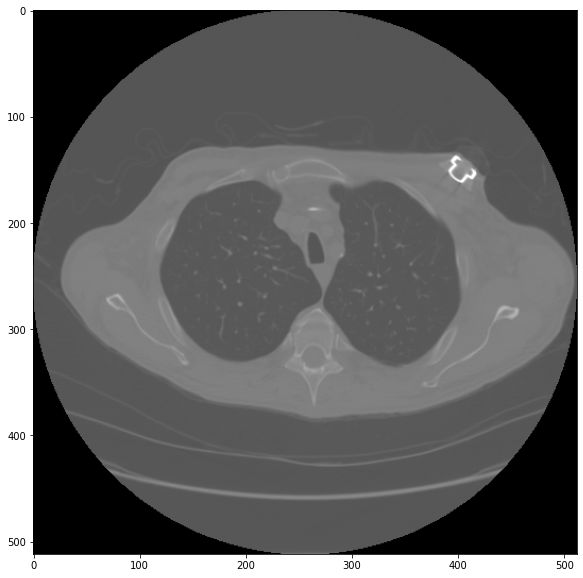

In [ ]:
# Let's visualize a slice
# Even by looking at the array shape we can tell that axis 0 is the z axis 
# and if we slice across it we will get axial slices

img = image_data[115,:,:]

plt.imshow(img,cmap = "gray")

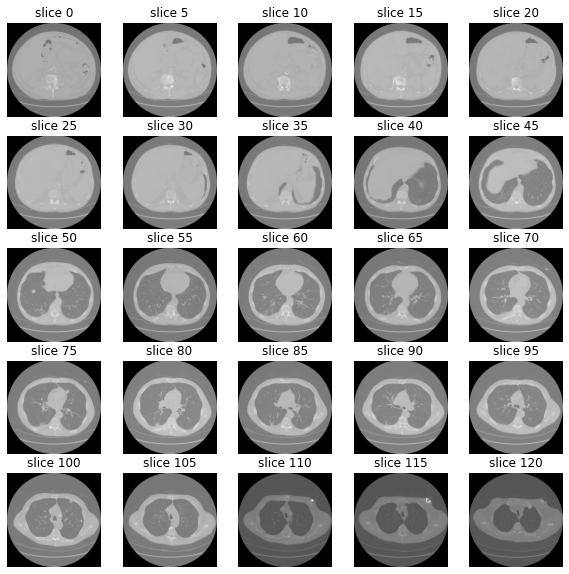

In [ ]:
#  Let's visualize a bunch of slices

fig, ax = plt.subplots(5, 5, figsize=[10,10])

for i in range(25):
    ix = i*int(len(slices)/25)
    ax[int(i/5), int(i%5)].set_title(f"slice {ix}")
    ax[int(i/5), int(i%5)].imshow(image_data[ix, :, :], cmap='gray')
    ax[int(i/5), int(i%5)].axis("off")

plt.show()

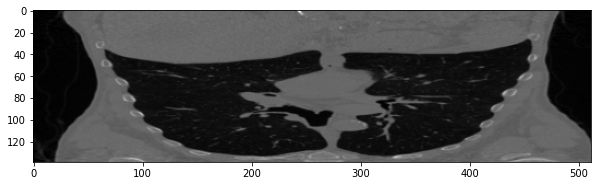

In [ ]:
# Let's do coronal slice now

img_coronal = image_data[:,250,:]
plt.imshow(img_coronal, cmap="gray")

Remember that our voxels are not isotropic? We need to scale along Z dimension to get proper representation


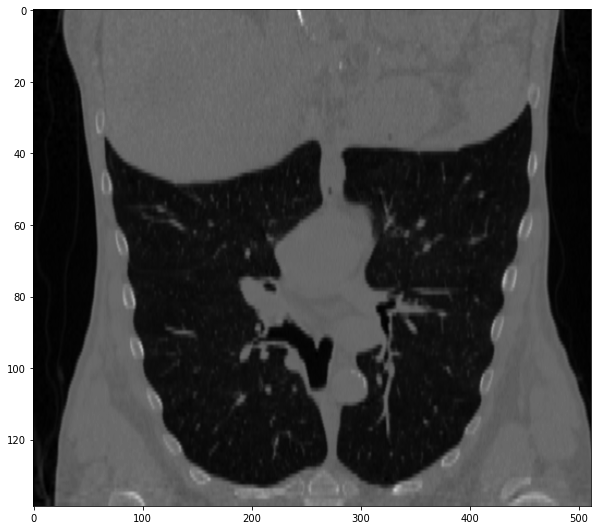

In [ ]:
aspect_ratio = slices[0].SliceThickness/slices[0].PixelSpacing[0]

plt.imshow(img_coronal, cmap="gray", aspect = aspect_ratio)

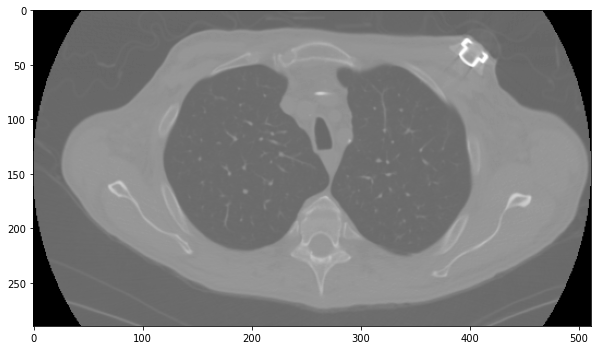

In [ ]:
# Let's crop our extracted slice a little to focus on the anatomy

img_crop = img[110:400,:]
plt.imshow(img_crop,cmap = cm.Greys_r)

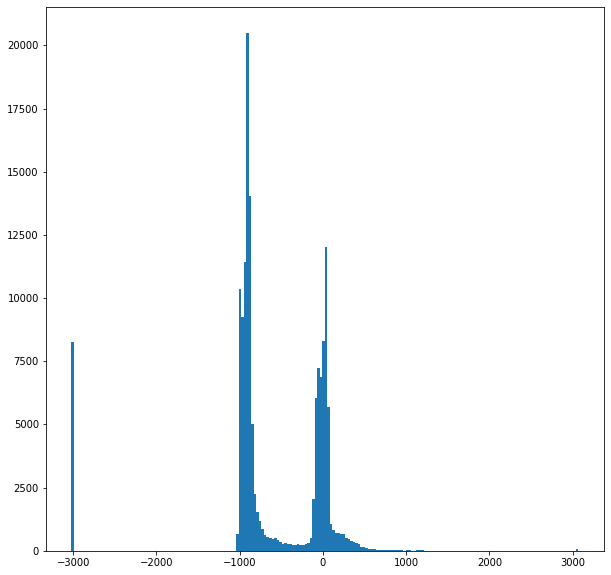

In [ ]:
# Let's visualize the histogram - what values do we have here?

p = img_crop.flatten()
# vals, bins, ignored = plt.hist(p[p>-900], bins = 200)
vals, bins, ignored = plt.hist(p, bins = 200)
plt.show()

In [ ]:
print(img_crop.max())
print(img_crop.min())

3071
-3024


### A reminder on Hounsfield Units
The Hounsfield scale is used to measure radiodensity and, in reference to medical-grade CT scans, can provide an accurate absolute density for the type of tissue depicted. 

https://en.wikipedia.org/wiki/Hounsfield_scale

<img src= "img/hu_j.png" width=400>

Looks good, but what is this extreme stuff? What's 3071 and -3024?

In [ ]:
# Let's look at the bottom end:

np.sort(np.unique(img_crop))

array([-3024, -1024, -1023, ...,  2972,  3037,  3071], dtype=int16)

So we can see that after a bunch of pixels valued at -3024 we immediately jump to -1024 which wits quite close to the range of the Hounsfield scale. This could lead you to believe that -3024 is not a result of reconstruction of the CT sinogram, but rather something that was added to the image later. And it is so, and it happens quite often - CT scanners add "magic" values to pad volumes to rectangles (since images are saved as rectangular grids of voxels). A large negative value is selected so that it does not overlap with values that would be legitimately present on an HU scale.

Now let's look at the upper end of that range

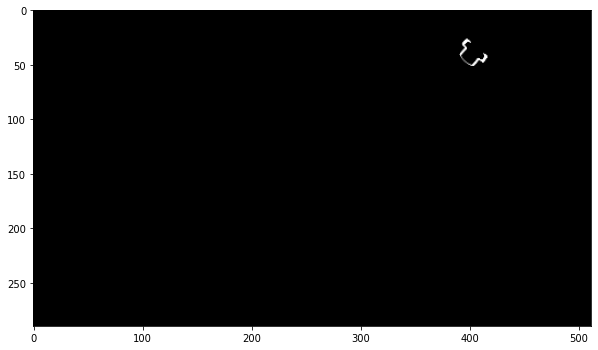

In [ ]:
# Let us apply the window

hu_min = 2000
hu_max = 4000

# Note that here we are using the Numpy's Masked Array module which allows us to mask values that fall outside of 
# range that interests us
# windowed_img = ma.masked_where((img_crop < hu_min) | (img_crop > hu_max), img_crop)
windowed_img = np.copy(img_crop)
windowed_img[np.where(windowed_img < hu_min)] = hu_min
windowed_img[np.where(windowed_img > hu_max)] = hu_max

# plt.imshow(ma.masked_array(data = img_crop, mask = img_crop > hu_max, fill_value = img_crop.min()).filled(), cmap = cm.Greys_r)
plt.imshow(windowed_img, cmap="gray")

In [ ]:
windowed_img.shape

(290, 512)

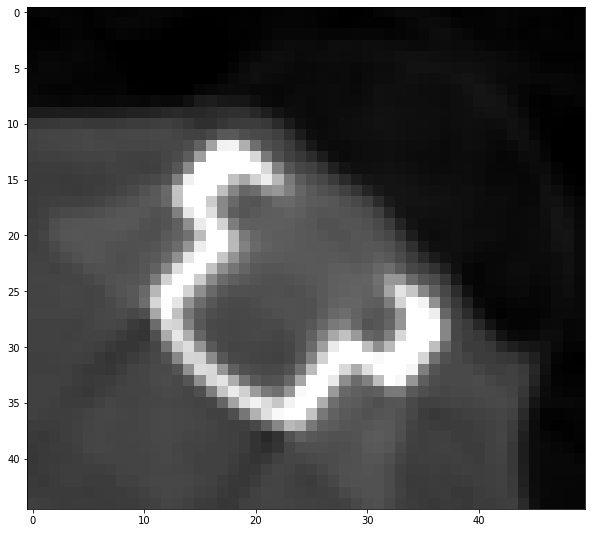

In [ ]:
# Let's zoom in on this thing a bit better

plt.imshow(img_crop[15:60, 380:430], cmap="gray")

In [ ]:
# Using numpy's Masked Array for convenience

masked = ma.masked_outside(img_crop, hu_min, hu_max)

np.sort(np.unique(img_crop[~masked.mask]))

array([2021, 2029, 2034, 2046, 2060, 2076, 2077, 2090, 2096, 2123, 2126,
       2143, 2150, 2160, 2169, 2212, 2236, 2254, 2317, 2337, 2342, 2350,
       2356, 2376, 2378, 2380, 2383, 2398, 2402, 2403, 2405, 2424, 2430,
       2436, 2456, 2460, 2463, 2496, 2497, 2516, 2529, 2545, 2554, 2570,
       2571, 2608, 2621, 2651, 2663, 2680, 2686, 2733, 2738, 2745, 2746,
       2768, 2784, 2794, 2823, 2837, 2857, 2865, 2873, 2882, 2916, 2946,
       2967, 2968, 2972, 3037, 3071], dtype=int16)

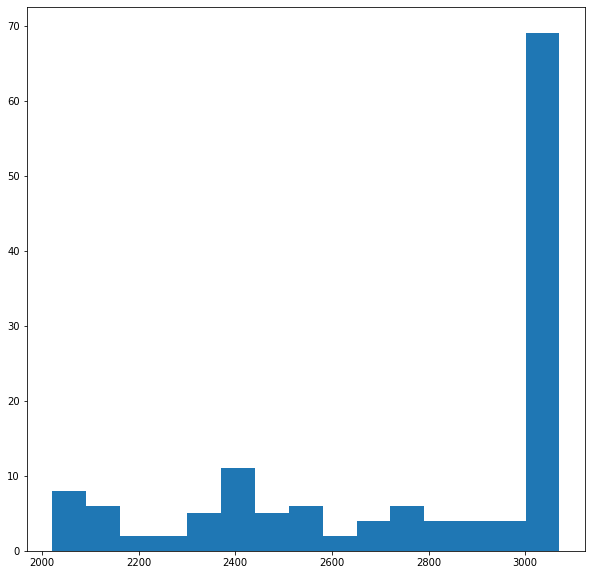

In [ ]:
# Let us see what values we have in our windowed range

_ = plt.hist(masked.flatten(), bins = 15)

plt.show()

That has to be a synthetic material. And it is - that is a chemotherapy port.

An interesting observation: original image's voxel range:

In [ ]:
print(f"range: {img_crop.max()-img_crop.min()}")

range: 6095
